# Кейс от VK: Ранжирование комментариев

In [1]:
# Основные библиотеки
import pandas as pd
import os
import numpy as np
from tqdm import notebook
import warnings

# Предобработка текста
import re
import torch
import transformers
import nltk
import language_tool_python
import spacy
import en_core_web_trf
from ipyparallel import require

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

# Загрузка необходимых файлов 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
grammar_tool = language_tool_python.LanguageTool('en-US')
nlp = spacy.load("en_core_web_trf")
warnings.filterwarnings("ignore")


# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Машинное обучение
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from catboost import CatBoostRegressor, Pool

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Исследовательский анализ

## Распаковка данных 

Распакуем данные из исходного файла ranking_train.jsonl в удобный для нас вид - DataFrame

In [2]:
full_train = pd.read_json('datasets/ranking_train.jsonl', lines= True)

small_train = full_train.loc[:199].reset_index(drop=True)

pre_train = pd.DataFrame(columns=['comment', 'score'])
for row in notebook.tqdm(range(len(small_train))):
    set_of_comments = pd.DataFrame.from_dict(small_train['comments'][row])
    set_of_comments = set_of_comments.rename(columns={'text':'comment'})
    pre_train = pd.concat([pre_train, set_of_comments], ignore_index=True)
pre_train["comment"] = pre_train["comment"].replace(0, np.nan).bfill()

pre_train['score'] = pre_train['score'].astype(str).astype(int)

  0%|          | 0/200 [00:00<?, ?it/s]

## Создаем необходимые функции для подсчета значимых признаков 

### Определил функции для подсчета всего нужного.
Первая группа для отдельного подсчета:  
1. count_words - Подсчет кол-ва слов
2. avg_word_length - Подсчет средней длины слова
3. stop_words - Подсчет кол-ва стоп-слов
4. count_sentences - Подсчет кол-ва предложений.
5. avg_sentence_length - Подсчет средней длины предложений в словах.
6. count_punctuation - Подсчет знаков препинания 
7. count_special_chars - Подсчет иных знаков(букв, знаков препинания и пробелов)
8. count_uppercase - Подсчет заглавных букв  
 
Вторая группа для подсчета переменных, составляющих индексы:   
9. gunning_fog_s - Индекс читаемости Ганнинга для оценки читаемости текста   
10. smog_s - Индекс удобочитаемости   
11. coleman_liau_s - Индекс удобочитаемости Колман - Лиау   
12. count_grammar - Подсчет кол-ва ошибок   
13. vader_compound_score - Индекс "настроения"   
14. count_n_grams - Подсчет количества биграмм  

In [3]:
#Функции для отдельного подсчета
def count_words(comment):
    #split into sen by RegExp
    sentences = re.findall(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', comment)

    if len(sentences) == 0:
        sentences.append(comment)
    else:
        sentences.append(comment[len(sentences[-1]):])
    
    # del punctuation marks except for apostrophe and hyphen from each sentence
    for i in range(len(sentences)):
        sentences[i] = re.sub(r'[^\w\s\'-]', '', sentences[i])
    
    # each sen split in words by RegExp
    words = []
    for sentence in sentences:
        words += re.findall(r'\b\w+\b', sentence)
    
    # return avg word len
    return len(words) if len(words) > 0 else 0

def avg_word_length(comment):
    #split into sen by RegExp
    sentences = re.findall(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', comment)

    if len(sentences) == 0:
        sentences.append(comment)
    else:
        sentences.append(comment[len(sentences[-1]):])
    
    # del punctuation marks except for apostrophe and hyphen from each sentence
    for i in range(len(sentences)):
        sentences[i] = re.sub(r'[^\w\s\'-]', '', sentences[i])
    
    # each sen split in words by RegExp
    words = []
    for sentence in sentences:
        words += re.findall(r'\b\w+\b', sentence)
    
    # return avg word len
    return sum(len(word) for word in words) / len(words) if len(words) > 0 else 0

def stop_words(comment):
    stop_words = set(stopwords.words('english'))
    common_words = set(comment.split()) & stop_words
    return len(common_words)

def count_sentences(comment):
    # the same operation like in previos func
    sentences = re.findall(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', comment)
    if len(sentences) == 0:
        return 1
    else:
        return len(sentences)

def avg_sentence_length(comment):
    sentences = re.findall(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', comment)
    if len(sentences) == 0:
        sentences.append(comment)
    else:
        sentences.append(comment[len(sentences[-1]):])

    for i in range(len(sentences)):
        sentences[i] = re.sub(r'[^\w\s\'-]', '', sentences[i])

    # split each sen into words using RegExp and count the number of words
    sentence_lengths = []
    for sentence in sentences:
        words = re.findall(r'\b\w+\b', sentence)
        sentence_lengths.append(len(words))

    # calculate the average length of each sentence in words
    avg_lengths = sum(sentence_lengths) / len(sentence_lengths) if len(sentence_lengths) > 0 else 0

    return avg_lengths

def count_punctuation(comment):
    # count the number of punctuation marks in sen usin string
    punctuation_count = sum([1 for char in comment if char in ['!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', '[', ']', '`']    ])
    return punctuation_count

def count_special_chars(comment):
    pattern = r"[^\w\s]"
    count = len(re.findall(pattern, comment))
    return count

def count_uppercase(sentence):
    # same, but usin isUpper
    uppercase_count = sum([1 for char in sentence if char.isupper()])
    return uppercase_count


#Функции для подсчета переменных, составляющих индексы

def gunning_fog_s(comment):
    words = re.findall(r'\w+', comment)
    sentences = re.split(r'[.!?]+', comment)
    complex_words = len([word for word in words if len(word) >= 3 and len(re.findall(r'[aeiouy]+', word.lower())) >= 3])
    if (len(sentences) == 0 or len(words) == 0): 
        return 20
    else:
        return 0.4 * ((len(words) / len(sentences)) + 100 * (complex_words / len(words)))

def smog_s(comment):
    import numpy as np
    words = re.findall(r'\w+', comment)
    sentences = re.split(r'[.!?]+', comment)
    poly_syllable_words = len([word for word in words if len(re.findall(r'[aiouy][aeiouy]{0,}', word.lower())) >= 3])
    if(len(sentences) == 0): return 38
    return 1.043 * np.sqrt(poly_syllable_words * (30 / len(sentences))) + 3.1291

def coleman_liau_s(comment):
    characters = len([char for char in comment if char.isalnum()])
    words = len(re.findall(r'\w+', comment))
    sentences = len(re.split(r'[.!?]+', comment))
    if (words == 0): return 17
    return 0.0588 * (characters / words) * 100 - 0.296 * (sentences / words) * 100 - 15.8

def count_grammar(comment):
    matches = grammar_tool.check(comment)
    return len(matches)

def vader_compound_score(comment):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
    return vader.polarity_scores(comment)['compound']

def count_n_grams(row):
    bgs = nltk.bigrams(row)
    return sum((nltk.FreqDist(bgs)).values())

def decode_for_uncode(row):
    return row.encode('ascii').decode('unicode-escape')


## Добавление новых столбцов

Добавим столбцы для которых не требуется лемматизация

In [4]:
pre_train['avg_word_len'] = [avg_word_length(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['number_of_sen'] = [count_sentences(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['avg_sen_len_in_words'] = [avg_sentence_length(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['punctuation_count'] = [count_punctuation(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['uppercase_let_count'] = [count_uppercase(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['gunning_fog_score'] = [gunning_fog_s(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['smog_score'] = [smog_s(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['coleman_liau_score'] = [coleman_liau_s(text) for text in notebook.tqdm(pre_train['comment'])]
pre_train['vader_compound_score'] = [vader_compound_score(text) for text in notebook.tqdm(pre_train['comment'])]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Добавим столбцы с лемматизированным текстом

In [5]:
train = pre_train
for row in notebook.tqdm(range(len(pre_train))):
    train['comment'][row] = re.sub(r'[^a-zA-Z ]', ' ', pre_train['comment'][row])
    train['comment'][row] = train['comment'][row].split()
    train['comment'][row] = " ".join(train['comment'][row])

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

pre_train['lemm_comment'] = pre_train['comment']
lemmatizer = WordNetLemmatizer()
for row in notebook.tqdm(range(len(pre_train))):
    pre_train['lemm_comment'][row] = nltk.word_tokenize(train['lemm_comment'][row])
    pre_train['lemm_comment'][row] = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in pre_train['lemm_comment'][row]])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Добавим столбцы для которых требовалась лемматизация и удалим текстовые столбцы, предварительно сохранив получившийся датафрейм

In [6]:
pre_train['comment_len'] = pre_train['comment'].str.len()
pre_train['number_of_words'] = [count_words(text) for text in pre_train['comment']]
pre_train["number_of_words"] = pre_train["number_of_words"].replace(0, np.nan).bfill()
#pre_train['grammar'] = [count_grammar(text) for text in notebook.tqdm(pre_train['lemm_comment'])]
pre_train['stop_words'] = [stop_words(text) for text in notebook.tqdm(pre_train['lemm_comment'])]
pre_train['n_grams'] = pre_train['lemm_comment'].apply((count_n_grams))

full_sample = pre_train.copy()
pre_train.drop(columns=['comment', 'lemm_comment'], inplace=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

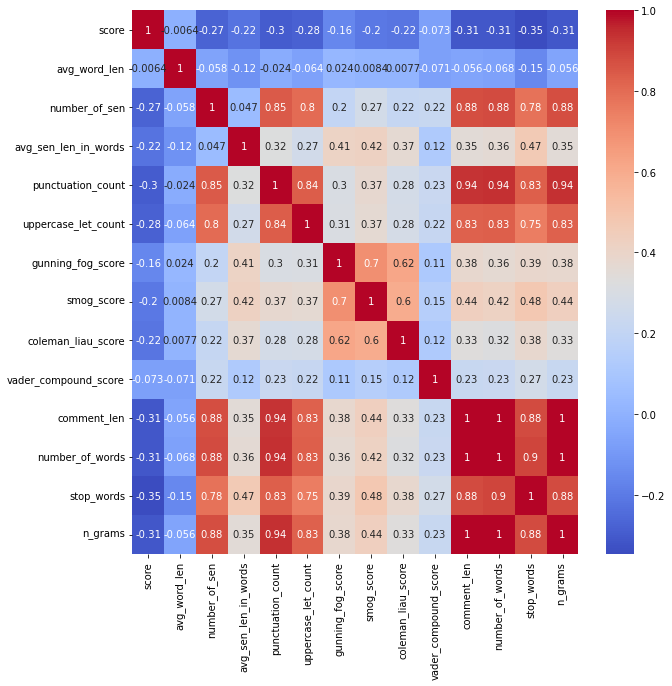

<Figure size 432x288 with 0 Axes>

In [7]:
corr_matrix = pre_train.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, ax = ax, cmap='coolwarm', annot=True)
plt.show()
plt.savefig('res.png')

## Подготовим данные для Машинного обучения

Сделаем тренировочную и валидацонную выборки 

In [15]:
def split_of_sample(sample):
    return sample.drop(['score', 'comment'], axis=1), sample['score']
train = full_sample.loc[:749]
valid = full_sample.loc[750:]
features_train, target_train = split_of_sample(train)
features_valid, target_valid = split_of_sample(valid)

target_train=target_train.astype('float64')
target_valid=target_valid.astype('float64')
print(f'{features_train.shape}/{target_train.shape}/{features_valid.shape}/{target_valid.shape}')

(750, 14)/(750,)/(250, 14)/(250,)


In [17]:
valid_index = features_valid.index
pd_text = pd.Series(features_valid['lemm_comment'], index=valid_index)

Для обучения модели будем использовать модель BERT, так что лемматизация не потребуется. Инициализируем токенизатор как объект класса BertTokenizer(). Передадим ему аргумент vocab_file — это файл со словарём, на котором обучалась модель (взят с сайта: https://docs.deeppavlov.ai/en/master/features/models/bert.html, *BERT-base, English, cased, 12-layer, 768-hidden, 12-heads, 110M parameters*).

In [18]:
tokenizer = transformers.BertTokenizer(vocab_file='datasets/vocab_L.txt')
tokenized_train = features_train['lemm_comment'].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=512, add_special_tokens = True))

max_len = 0
for i in tokenized_train.values:
    if len(i) > max_len:
        max_len = len(i)

padded_train = np.array([i + [0]*(max_len - len(i)) for i in tokenized_train.values])

attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_train.shape

(750, 512)

Инициализируем конфигурацию BertConfig. В качестве аргумента передадим ей JSON-файл с описанием настроек модели.
Затем инициализируем саму модель класса BertModel. Передадим ей файл с предобученной моделью и конфигурацией (все файлы взяты с сайта: https://huggingface.co/bert-base-uncased/tree/main):

In [19]:
config = transformers.BertConfig.from_json_file('datasets/config.json')
model = transformers.BertModel.from_pretrained('datasets/pytorch_model.bin', config=config)

Some weights of the model checkpoint at datasets/pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Начнём преобразование текстов в эмбеддинги. Это может занять несколько минут, поэтому подключим библиотеку tqdm. Она нужна, чтобы наглядно показать индикатор прогресса.

In [45]:
batch_size = 50        # Чтобы хватило оперативной памяти, сделаем размер батча небольшим
embeddings = []
for i in notebook.tqdm(range(padded_train.shape[0] // batch_size)):        # Сделаем цикл по батчам
    batch = torch.LongTensor(padded_train[batch_size*i:batch_size*(i+1)])
    attention_mask_train_batch = torch.LongTensor(attention_mask_train[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():        #Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.
        batch_embeddings = model(batch, attention_mask=attention_mask_train_batch)        # Чтобы получить эмбеддинги для батча, передадим модели данные и маску:
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/15 [00:00<?, ?it/s]

In [47]:
features_train_emb = pd.DataFrame(np.concatenate(embeddings), index=features_train.index)
features_train_full = features_train_emb.join(features_train, how='outer').drop('lemm_comment', axis=1)

Сделаем то же самое с валидационной выборкой

In [48]:
tokenizer = transformers.BertTokenizer(vocab_file='datasets/vocab_L.txt')
tokenized_valid = features_valid['lemm_comment'].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=512, add_special_tokens = True))

max_len = 0
for i in tokenized_valid.values:
    if len(i) > max_len:
        max_len = len(i)

padded_valid = np.array([i + [0]*(max_len - len(i)) for i in tokenized_valid.values])

attention_mask_valid = np.where(padded_valid != 0, 1, 0)
attention_mask_valid.shape

embeddings = []
for i in notebook.tqdm(range(padded_valid.shape[0] // batch_size)):        # Сделаем цикл по батчам
    batch = torch.LongTensor(padded_valid[batch_size*i:batch_size*(i+1)])
    attention_mask_valid_batch = torch.LongTensor(attention_mask_valid[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():        #Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.
        batch_embeddings = model(batch, attention_mask=attention_mask_valid_batch)        # Чтобы получить эмбеддинги для батча, передадим модели данные и маску:
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

features_valid_emb = pd.DataFrame(np.concatenate(embeddings), index=valid_index)
features_valid_full = pd.merge(features_valid, features_valid_emb, how='outer').drop('lemm_comment', axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [49]:
features_valid_emb = pd.DataFrame(np.concatenate(embeddings), index=valid_index)
features_valid_full = pd.merge(features_valid, features_valid_emb, how='outer').drop('lemm_comment', axis=1)

## Обучение модели CatBoostRegressor

In [50]:
final_cat = CatBoostRegressor(depth=8, 
                              learning_rate=0.3,
                              loss_function='MAE',verbose=100)
final_cat.fit(Pool(features_train_full, target_train))

0:	learn: 1.1011991	total: 756ms	remaining: 12m 35s
100:	learn: 0.0446391	total: 36.2s	remaining: 5m 21s
200:	learn: 0.0101843	total: 1m 11s	remaining: 4m 42s
300:	learn: 0.0034043	total: 1m 45s	remaining: 4m 6s
400:	learn: 0.0013923	total: 2m 20s	remaining: 3m 30s
500:	learn: 0.0003855	total: 2m 55s	remaining: 2m 54s
600:	learn: 0.0001103	total: 3m 30s	remaining: 2m 19s
700:	learn: 0.0000336	total: 4m 5s	remaining: 1m 44s
800:	learn: 0.0000111	total: 4m 39s	remaining: 1m 9s
900:	learn: 0.0000027	total: 5m 14s	remaining: 34.6s
999:	learn: 0.0000007	total: 5m 49s	remaining: 0us


Сделаем предсказания на валидационной выборке

In [51]:
predictions = pd.Series(final_cat.predict(features_valid_full))
features_valid = pd.DataFrame(features_valid_full)
features_valid['score'] = predictions

Рассчитаем метрику accuracy, чтобы понять качество предсказания

In [63]:
accuracy_score((features_valid['score']).astype('int64'), target_valid)

0.256